Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/05.working_with_data_and_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install -q torchinfo torchviz

In [2]:
import requests, zipfile, io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Working with data and datasets

## Representing real-world data
Real-world data comes in different forms, and it is important that data is represented properly before being used to train a machine learning model. Data usually has two parts: input and output. The input data consists of one or more features. The number of these features determines the dimensionality of the data. The IRIS dataset, for example, has *4* input features, meaning that it is 4-dimensional. The output part exists only in supervised learning and consists of one or more columns called targets.

Let's look at the most common four kinds of data we come across when working with deep learning.

### Working with tabular data
Most machine learning problems, including all the examples we have seen so far, deal with tabular data. Let's see another example using the [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality) dataset from UC Irvine Machine Learning Repository.

First we down the zip file containing the data, then we read the specific file where the data resides:

In [3]:
url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
data_filename = "winequality-white.csv"

zf = zipfile.ZipFile(io.BytesIO(requests.get(url).content)).open(data_filename)

We can now use Pandas to read the data, keeping in mind that this data is sparated using semicolons instead of commas.

In [4]:
df = pd.read_csv(zf, sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


The data is a table with rows and columns. There are 12 columns. The first 11 columns represent the input feature and the last comlumn is the output. Here are the column names:

In [5]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

Here is the input portion of this data in a PyTorch tensor array.

In [6]:
X = torch.from_numpy(df.iloc[:, :-1].values)
X.shape, X.dtype

(torch.Size([4898, 11]), torch.float64)

and here is the output:

In [7]:
y = torch.from_numpy(df.iloc[:, -1].values)
y.shape, y.dtype

(torch.Size([4898]), torch.int64)

Looking at the target more closely, it has the following unique values:

In [8]:
torch.unique(y)

tensor([3, 4, 5, 6, 7, 8, 9])

It looks like a categorical column and we can, depending on the problem:
* keep it the way it is.
* re-code its values.
* one-hot encode it.

Let's see how we can do the last two. First we recade the values

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(y)
y_hat = torch.from_numpy(encoder.transform(y))
y_hat.shape

torch.Size([4898])

Here are the original values:

In [10]:
encoder.classes_

array([3, 4, 5, 6, 7, 8, 9])

And here are the new unique values:

In [11]:
torch.unique(y_hat)

tensor([0, 1, 2, 3, 4, 5, 6])

In [12]:
y_onehot = torch.zeros(y_hat.shape[0], 7)
y_onehot.scatter_(1, y_hat.unsqueeze(1), 1.0)

y_onehot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

For example, the 1000th example (row) has a target of:

In [13]:
y[999]

tensor(7)

which is encoded to:

In [14]:
np.where(encoder.classes_ == y[999].item())

(array([4]),)

And its one-hot encoded value is:

In [15]:
y_onehot[999]

tensor([0., 0., 0., 0., 1., 0., 0.])

### Working with images

Data as we shall see later in this course can be made of images. There could be black and white, grey, and color images. Here is an example color image:

In [16]:
import imageio

img_arr = imageio.v3.imread('https://images.unsplash.com/photo-1483221545928-50dd3b5882ea')
img_arr.shape

(3648, 5472, 3)

This image is 3648 pixel high, 5472 pixel wide and it has three color channels: red, green, and blue. This representing can be called HWC (H for height, W for width, and C for channels). Let's display this image:

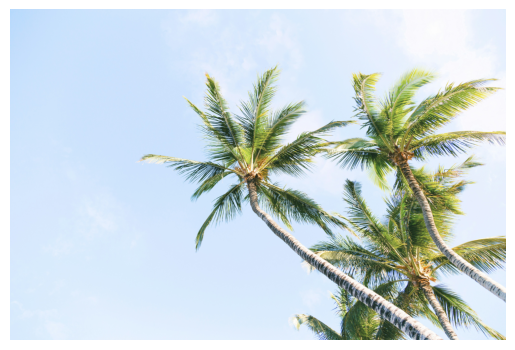

In [17]:
plt.axis('off')
plt.imshow(img_arr)

A dataset with N images like this will have the shape (N, H, W, C) which means (Number of samples, Height, Width, Channels). This data layout format works for frameworks like Tensorflow. PyTorch however, requires a different layout: (N, C, H, W).

In [18]:
img_hwc = torch.from_numpy(img_arr)
img_chw = img_hwc.permute(2, 0, 1)
img_chw.shape

torch.Size([3, 3648, 5472])

With this new layout, it's easy to standardize each channel.

### Working with sequential data

Many problems involve sequential data. This data is characterized by the fact that order is important. This goes against the i.i.d assumption we have been working under in all our previous examples. Many learning tasks however involves sequential data, which canb of two main types:
* Time series sequences where time is a dimension of the data. Examples of such data are stock prices in a trading app updated every minute or weekly gas prices.
* Natural language sequences such as characters in words or or words in word sequences.

Let's see an example of time series data. In this example, the Jena Climate data set will be used. This is a popular weather time series data set recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. The Jena Climate data set is made up of 14 different features (such air temperature, atmospheric pressure, humidity, wind direction, and so on) recorded every 10 minutes, over several years. This data set covers data from January 1, 2009 to December 31, 2016.

Let's download and unzip the data.

In [19]:
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
data_filename = "jena_climate_2009_2016.csv"

zf = zipfile.ZipFile(io.BytesIO(requests.get(url).content)).open(data_filename)

raw_df = pd.read_csv(zf)
raw_df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


As you can see, there is a **Date Time** column at which the values of the other columns are recorded. This data set has one reading example every 10 minutes. The date/time values are in the German format (**day.month.year hours24:minutes:seconds**).

Pandas comes with an awesome set of functions that make working with time series data like this a breeze. To "convert" this dataframe into a time series we first convert the `Date Time` column from string to Pandas's "DateTime" type.

In [20]:
raw_df["Date Time"] = pd.to_datetime(raw_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

Let's check and verify the data types of the columns of this data frame:

In [21]:
raw_df.dtypes

,0
Date Time,datetime64[ns]
p (mbar),float64
T (degC),float64
Tpot (K),float64
Tdew (degC),float64
rh (%),float64
VPmax (mbar),float64
VPact (mbar),float64
VPdef (mbar),float64
sh (g/kg),float64


We are looking for  Date Time column having the `datetime64[ns]` type. We can now use this date/time column as an index for this whole data set. Let's also remove any possible duplicates.

In [22]:
df = raw_df.set_index('Date Time').drop_duplicates()
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


Let's plot all of these columns for the first year so we can get an idea of how these columns behave over time:

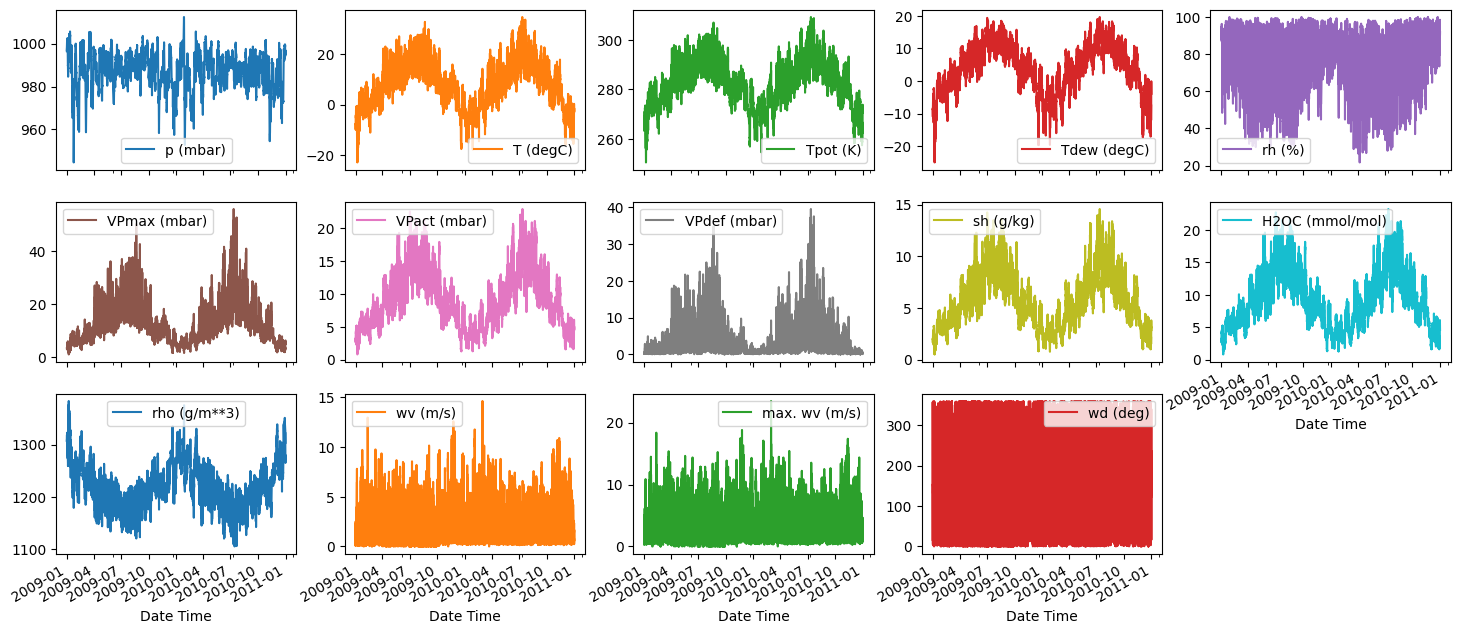

In [23]:
df['2009' : '2010'].plot(subplots=True,layout=(3, 5), figsize=(18, 8))
plt.show()

The last two columns show the least patterns over time. Let's exclude them and plot again:

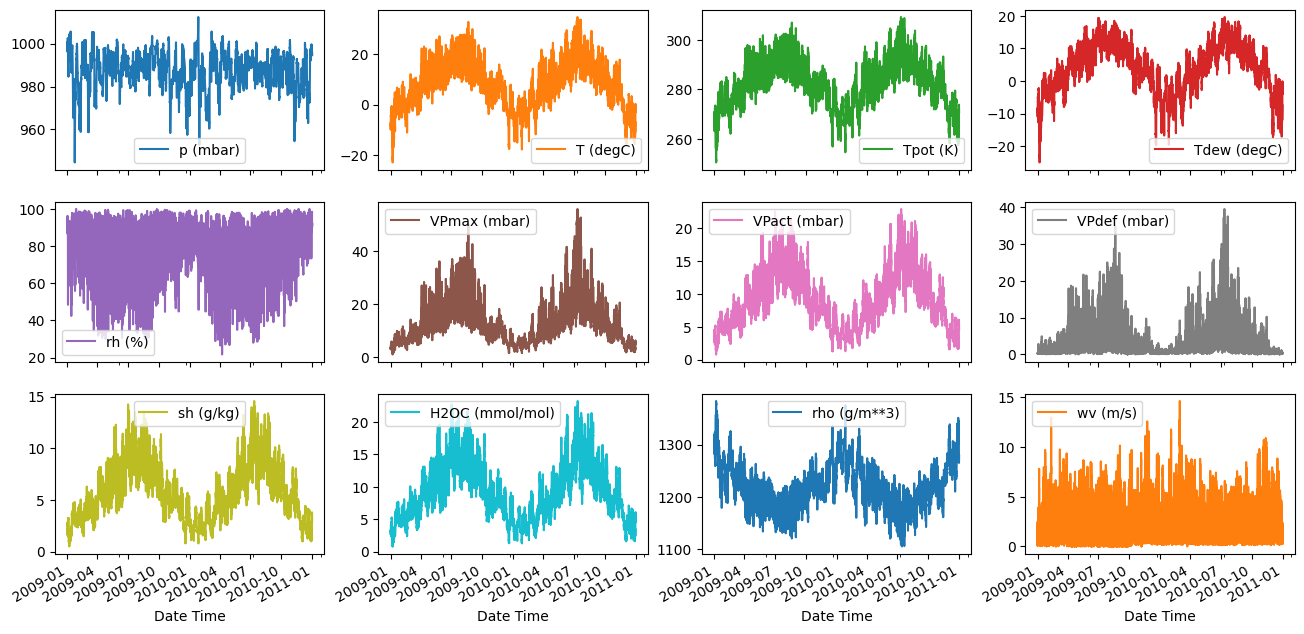

In [24]:
df = df.loc[:, :"wv (m/s)"]

df['2009' : '2010'].plot(subplots=True,layout=(3, 4), figsize=(16, 8))
plt.show()

## Working with datasets and data loaders

PyTorch provides two powerful utilities for working with datasets, especially 'big data': datasets and data loaders. As we know, supervised models require datasets with two parts: input and output. Datasets allow us to maintain the correspondence between these two parts. While we have been able to get by without these utilities so far due to the small size of the datasets we have been using, these tools are extremely important for large datasets, especially those that are too big to fit in memory. Think of a dataset with thousands of high-resolution images, audios, or videos.

In addition to handling large datasets, datasets allow for creating data preprocessing pipelines called transforms, which we will see later in the course. Let's start by examining how we can create datasets from regular tensors.

Let's generate some random input and output data:

In [25]:
X_data = torch.randint(100, 1000, size=(10, 3))
y_data = torch.tensor([0,0,0,0,0,1,1,1,1,1])
X_data.dtype, y_data.dtype

(torch.int64, torch.int64)

### Creating a dataset

Creating a dataset using these two tensors ensures that the correspondence between them is kept intact during the mini-batching and shuffling needed during model training. To do so, we write a simple class inheriting from `torch.utils.data.Dataset`. At a minimum, this class will need to have three methods: `__init__`, `__len__`, and `__getitem__`. These methods are necessary to create a map-based dataset interface that is easy to work with and iterate over.

In [26]:
from torch.utils.data import Dataset

class JointDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Let's use this class to create a dataset using the `X` and `y` tensors.

In [27]:
ds = JointDataset(X_data, y_data)

Here is how many examples (instances) in this new dataset.

In [28]:
len(ds)

10

We we can iterate over the examples of this dataset using a simple `for` loop like this:

In [29]:
for x, y in ds:
    print(x, y)

tensor([761, 238, 589]) tensor(0)
tensor([247, 871, 729]) tensor(0)
tensor([398, 350, 886]) tensor(0)
tensor([869, 253, 212]) tensor(0)
tensor([341, 974, 694]) tensor(0)
tensor([763, 368, 486]) tensor(1)
tensor([266, 358, 187]) tensor(1)
tensor([216, 672, 896]) tensor(1)
tensor([409, 318, 138]) tensor(1)
tensor([433, 540, 230]) tensor(1)


or:

In [30]:
for d in iter(ds):
    print(d)

(tensor([761, 238, 589]), tensor(0))
(tensor([247, 871, 729]), tensor(0))
(tensor([398, 350, 886]), tensor(0))
(tensor([869, 253, 212]), tensor(0))
(tensor([341, 974, 694]), tensor(0))
(tensor([763, 368, 486]), tensor(1))
(tensor([266, 358, 187]), tensor(1))
(tensor([216, 672, 896]), tensor(1))
(tensor([409, 318, 138]), tensor(1))
(tensor([433, 540, 230]), tensor(1))


And we can convert a dataset to a list of input-output tuples.

In [31]:
list(ds)

[(tensor([761, 238, 589]), tensor(0)),
 (tensor([247, 871, 729]), tensor(0)),
 (tensor([398, 350, 886]), tensor(0)),
 (tensor([869, 253, 212]), tensor(0)),
 (tensor([341, 974, 694]), tensor(0)),
 (tensor([763, 368, 486]), tensor(1)),
 (tensor([266, 358, 187]), tensor(1)),
 (tensor([216, 672, 896]), tensor(1)),
 (tensor([409, 318, 138]), tensor(1)),
 (tensor([433, 540, 230]), tensor(1))]

### Using TensorDataset

If your dataset is as simple as the `JointDataset` above, then there is no need to even create a class like this. You can use the `TensorDataset` instead.

In [32]:
from torch.utils.data import TensorDataset
tds = TensorDataset(X_data, y_data)
list(tds)

[(tensor([761, 238, 589]), tensor(0)),
 (tensor([247, 871, 729]), tensor(0)),
 (tensor([398, 350, 886]), tensor(0)),
 (tensor([869, 253, 212]), tensor(0)),
 (tensor([341, 974, 694]), tensor(0)),
 (tensor([763, 368, 486]), tensor(1)),
 (tensor([266, 358, 187]), tensor(1)),
 (tensor([216, 672, 896]), tensor(1)),
 (tensor([409, 318, 138]), tensor(1)),
 (tensor([433, 540, 230]), tensor(1))]

And we can get the input portion of this dataset like this:

In [33]:
tds.tensors[0]

tensor([[761, 238, 589],
        [247, 871, 729],
        [398, 350, 886],
        [869, 253, 212],
        [341, 974, 694],
        [763, 368, 486],
        [266, 358, 187],
        [216, 672, 896],
        [409, 318, 138],
        [433, 540, 230]])

Similarly, here is the output portion:

In [34]:
tds.tensors[1]

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Getting tensors from a dataset

We can retrieve the tensors of a given dataset like this:

In [35]:
X_train = torch.stack([x for x, _ in ds])
y_train = torch.stack([y for _, y in ds])

X_train, y_train

(tensor([[761, 238, 589],
         [247, 871, 729],
         [398, 350, 886],
         [869, 253, 212],
         [341, 974, 694],
         [763, 368, 486],
         [266, 358, 187],
         [216, 672, 896],
         [409, 318, 138],
         [433, 540, 230]]),
 tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

### Splitting datasets

Given a dataset, one can use `torch.utils.data.random_split` to split it into two or more sets. Here is an example, taking the above `JointDataset` and splitting it into training and testing sets.

In [36]:
from torch.utils.data import random_split

ds_train, ds_test = random_split(ds, [6, 4])

Let's print these datasets. Here is the training split:

In [37]:
list(ds_train)

[(tensor([341, 974, 694]), tensor(0)),
 (tensor([869, 253, 212]), tensor(0)),
 (tensor([398, 350, 886]), tensor(0)),
 (tensor([761, 238, 589]), tensor(0)),
 (tensor([409, 318, 138]), tensor(1)),
 (tensor([216, 672, 896]), tensor(1))]

And here is the testing split:

In [38]:
list(ds_test)

[(tensor([266, 358, 187]), tensor(1)),
 (tensor([247, 871, 729]), tensor(0)),
 (tensor([433, 540, 230]), tensor(1)),
 (tensor([763, 368, 486]), tensor(1))]

Here is another example splitting the above `TensorDataset` into three sets.

In [39]:
tds_train, tds_val, tds_test = random_split(ds, [.6, .15, .25])

len(tds_train), len(tds_val), len(tds_test)

(7, 1, 2)

## Dataloaders: Shuffle, batch and repeat

Training a neural network using gradient-based optimization requires feeding the training data to the model in batches. In addition, training requires going over the dataset many times (epochs). To faciitate this, PyTorch provides `torch.utils.data.DataLoader`. It allows for shuffling the data, serving it to the model in batches, and going over it mutilple times. These operations are called shuffle, batch, and repeat respectivly. When using this class, we pass it a dataset, specify the batch size, and whether or not to shuffle the data.

Here is an example data loader using the above `JointDataset`.

Training a neural network using gradient-based optimization requires feeding the training data to the model in batches. In addition, training requires going over the dataset many times (epochs). To facilitate this, PyTorch provides the `torch.utils.data.DataLoader` class. It allows for shuffling the data, serving it to the model in batches, and going over it multiple times. These operations are called **shuffle, batch, and repeat**, respectively. When using this class, we pass it a dataset, specify the batch size, and indicate whether or not to shuffle the data.

Here is an example data loader using the above `JointDataset`.

In [40]:
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=2, shuffle=True)

Here is how many batches:

In [41]:
len(dl)

5

And here is one iteration over the dataset in batches:

In [42]:
for i, batch in enumerate(dl):
    print(f"Batch {i}: {batch}")

Batch 0: [tensor([[869, 253, 212],
        [409, 318, 138]]), tensor([0, 1])]
Batch 1: [tensor([[266, 358, 187],
        [216, 672, 896]]), tensor([1, 1])]
Batch 2: [tensor([[433, 540, 230],
        [341, 974, 694]]), tensor([1, 0])]
Batch 3: [tensor([[763, 368, 486],
        [398, 350, 886]]), tensor([1, 0])]
Batch 4: [tensor([[761, 238, 589],
        [247, 871, 729]]), tensor([0, 0])]


And we can decompose batches to their input and output portions.

In [43]:
for i, (X, y) in enumerate(dl):
    print(f"Batch {i}:\n X={X},\n y={y}")

Batch 0:
 X=tensor([[761, 238, 589],
        [266, 358, 187]]),
 y=tensor([0, 1])
Batch 1:
 X=tensor([[433, 540, 230],
        [409, 318, 138]]),
 y=tensor([1, 1])
Batch 2:
 X=tensor([[869, 253, 212],
        [247, 871, 729]]),
 y=tensor([0, 0])
Batch 3:
 X=tensor([[398, 350, 886],
        [216, 672, 896]]),
 y=tensor([0, 1])
Batch 4:
 X=tensor([[341, 974, 694],
        [763, 368, 486]]),
 y=tensor([0, 1])


The last loop goes through the dataset once. We can go over it multiple times. Each time is called **an epoch**. Here is an example with two epochs:

In [44]:
for epoch in range(2):
    print(f'epoch {epoch + 1}')
    for i, batch in enumerate(dl, 1):
        print(f'batch {i}:', (batch))

epoch 1
batch 1: [tensor([[216, 672, 896],
        [266, 358, 187]]), tensor([1, 1])]
batch 2: [tensor([[763, 368, 486],
        [869, 253, 212]]), tensor([1, 0])]
batch 3: [tensor([[247, 871, 729],
        [761, 238, 589]]), tensor([0, 0])]
batch 4: [tensor([[341, 974, 694],
        [409, 318, 138]]), tensor([0, 1])]
batch 5: [tensor([[398, 350, 886],
        [433, 540, 230]]), tensor([0, 1])]
epoch 2
batch 1: [tensor([[398, 350, 886],
        [409, 318, 138]]), tensor([0, 1])]
batch 2: [tensor([[216, 672, 896],
        [247, 871, 729]]), tensor([1, 0])]
batch 3: [tensor([[761, 238, 589],
        [341, 974, 694]]), tensor([0, 0])]
batch 4: [tensor([[869, 253, 212],
        [763, 368, 486]]), tensor([0, 1])]
batch 5: [tensor([[433, 540, 230],
        [266, 358, 187]]), tensor([1, 1])]


## Training models using a dataset and a dataloader

We conclude this notebook with an example that demonstrates how datasets and dataloaders are used to train a model. Here is the data from the previous notebook:

In [45]:
count = 100

means = torch.tensor([[1., 5.], [7., 8.], [10., 2.]])
cov_mats = torch.tensor([
    [[1.5, .6], [.6, 1]], [[2, 0.8], [0.8, 2]], [[2.5, 0.7], [0.7, 2.5]]
])
data = []
for i in range(3):
    data.append(torch.distributions.MultivariateNormal(means[i], cov_mats[i]).sample((count,)))

X = torch.concat(data, axis=0)

y = torch.concat((torch.zeros(count), torch.ones(count), torch.full((count,), 2.)), axis=0).long()

X.shape, y.shape

(torch.Size([300, 2]), torch.Size([300]))

Let's split these tensors into three sets:

In [46]:
n = len(X)
shuffled = torch.randperm(n)
splits = (torch.tensor([.68, .16, .16]) * n).int().cumsum(0)
X_train, X_val, X_test = X[shuffled][:splits[0]], X[shuffled][splits[0]:splits[1]], X[shuffled][splits[1]:]
y_train, y_val, y_test = y[shuffled][:splits[0]], y[shuffled][splits[0]:splits[1]], y[shuffled][splits[1]:]
X_train.shape, y_train.shape

(torch.Size([204, 2]), torch.Size([204]))

Let's plot the training data:

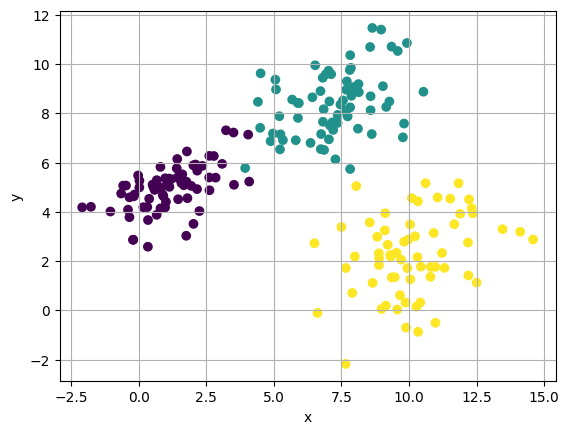

In [47]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

And we need to standardize the data based on the training set. Let's calculate and means and standard deviations.

In [48]:
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
mean, std

(tensor([6.0041, 5.2562]), tensor([4.0341, 2.8180]))

We are ready to use datasets. We start by creating a dataset that not only contains these tensors but also normalizes (standardizes) them.

In [49]:
class NormalizedDataset(Dataset):
    def __init__(self, X, y, mean, std):
        self.X = (X - mean)/std
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds_train = NormalizedDataset(X_train, y_train, mean, std)
ds_val = NormalizedDataset(X_val, y_val, mean, std)
ds_test = NormalizedDataset(X_test, y_test, mean, std)

Next we create data loaders for these datasets:

In [50]:
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=4, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=4, shuffle=True)

We now create a neural network model. We'll use the model from the previous notebook.

In [51]:
mlp = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 3)
)

from torchinfo import summary
summary(mlp)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            24
├─ReLU: 1-2                              --
├─Linear: 1-3                            72
├─ReLU: 1-4                              --
├─Linear: 1-5                            72
├─ReLU: 1-6                              --
├─Linear: 1-7                            72
├─ReLU: 1-8                              --
├─Linear: 1-9                            27
Total params: 267
Trainable params: 267
Non-trainable params: 0

Let's plot it:

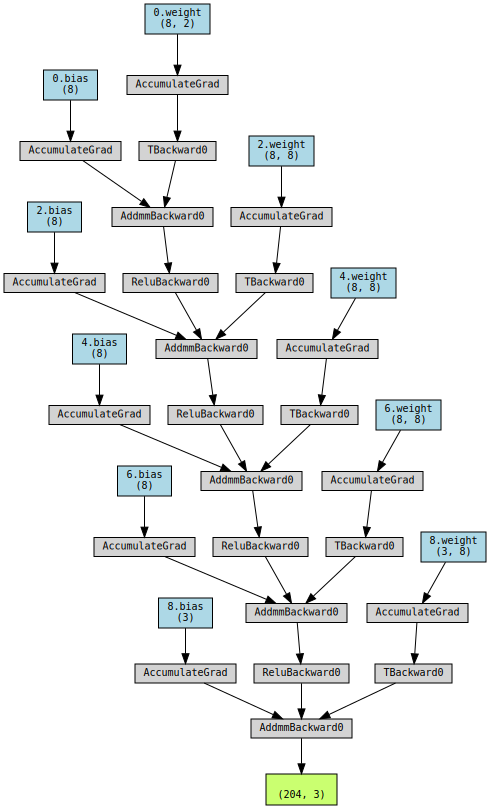

In [52]:
from torchviz import make_dot
make_dot(mlp(X_train), params=dict(mlp.named_parameters()))

Here are the loss function and optimizer we'll use to train this model

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=.001)

Here is the new training loop using the data loaders we created above:

In [54]:
epochs = 20
hist = dict(loss=[0] * epochs, val_loss= [0] * epochs, accuracy=[0] * epochs, val_accuracy=[0] * epochs)

for epoch in range(epochs):
    for x_batch, y_batch in dl_train:
        pred = mlp(x_batch)
        loss = loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        hist['loss'][epoch] += loss.item()
        hist['accuracy'][epoch] += (torch.argmax(pred, dim=1) == y_batch).float().sum().item()

    # Validation step (optional)
    with torch.no_grad():
        for x_batch, y_batch in dl_val:
            val_pred = mlp(x_batch)
            val_loss = loss_fn(val_pred, y_batch)

            hist['val_loss'][epoch] += val_loss.item()
            hist['val_accuracy'][epoch] += (torch.argmax(val_pred, dim=1) == y_batch).float().sum().item()

    hist['loss'][epoch] /= len(dl_train)
    hist['accuracy'][epoch] /= len(dl_train.dataset)
    hist['val_loss'][epoch] /= len(dl_val)
    hist['val_accuracy'][epoch] /= len(dl_val.dataset)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: 4d}: loss={hist['loss'][epoch]:.4f}\taccuracy={hist['accuracy'][epoch]:.4f}\tval_loss={hist['val_loss'][epoch]:.4f}\tval_accuracy={hist['val_accuracy'][epoch]:.4f}")


Epoch    1: loss=1.1372	accuracy=0.3480	val_loss=1.1205	val_accuracy=0.3333
Epoch   10: loss=0.0594	accuracy=0.9902	val_loss=0.0474	val_accuracy=0.9792
Epoch   20: loss=0.0295	accuracy=0.9902	val_loss=0.0322	val_accuracy=0.9792


As you can see, both the training and validation loaders are used. The validation step is optional, but it allows us to periodically evaluate the model on the validation set to monitor its performance during training. It's done under the torch.no_grad() scope to prevent PyTorch from tracking and calculating gradients during training.

Now, let's plot the training curves. We will use the historical data collected during training.As you can see, both the training and validation loaders are used. The validation step is optional it allows us to periodically evaluate the model on the validation set to monitor its performance during training. It's done under the `torch.no_grad()` scope so as to prevent PyTorch from tracking and calculating gradients during training.

Let plot the training curves; we will use the history data collected during training.

array([[<Axes: >, <Axes: >]], dtype=object)

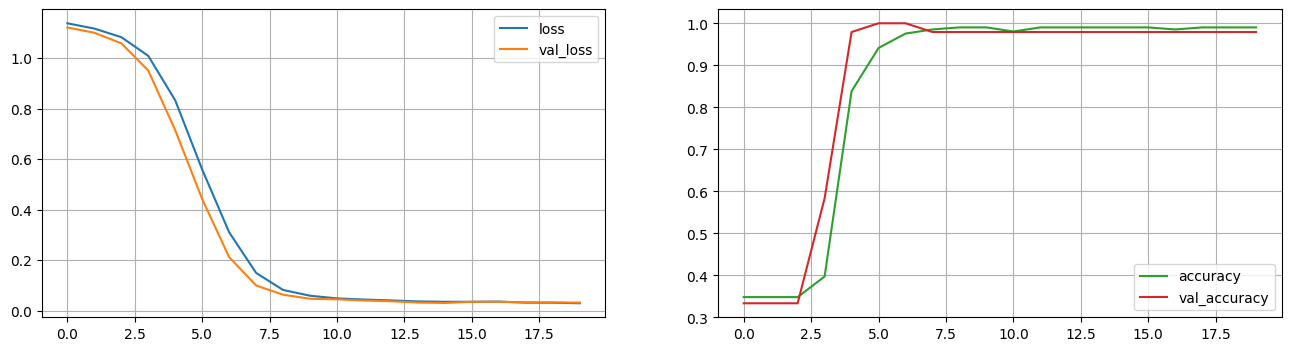

In [55]:
pd.DataFrame(hist).plot(subplots=[('loss', 'val_loss'), ('accuracy', 'val_accuracy')],
                        layout=(1,2), figsize=(16,4), grid=True)

Let's evaluate the trained model on the testing set, starting with normalizing the testing input data

Accuracy:  0.98


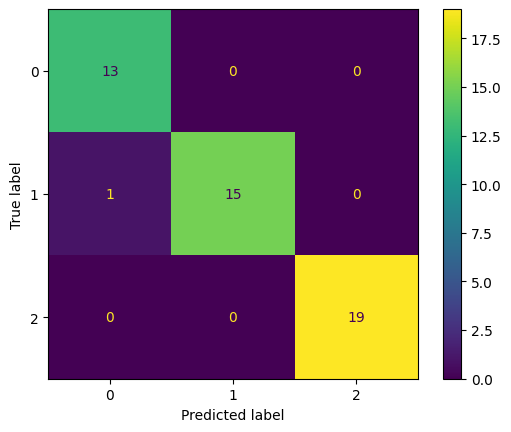

In [56]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

X_test_normalized = (X_test - mean) / std
predictions = mlp(X_test_normalized).argmax(dim=1)

print(f"Accuracy: {accuracy_score(y_test, predictions): .2f}")
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

Happy learning!